# Direct modelling of Greenland VLP surface waves

> Claudio Satriano
>
> satriano@ipgp.fr
>
> Institut de physique du globe de Paris, France
>
> October 2023
>
> With further small modifications made by Stephen Hicks

## Parameters

No inversion! Just a forward modelling exercise.

So you need to manually tune the parameters below to get a good fit.

In [358]:
# Parameters
# fjord axis is used to orient the forces
FJORD_AXIS_AZIMUTH_NORTH = 70  # degrees north (NdegE)
# fjord width is used to place the vertical couple of forces
FJORD_WIDTH_IN_METERS = 2880
SOURCE_LATITUDE = 72.835
SOURCE_LONGITUDE = -26.987
SOURCE_DEPTH_IN_METERS = 540
HORIZONTAL_FORCE_MAGNITUDE_IN_NEWTON = 5e11 #5e11
VERTICAL_FORCE_MAGNITUDE_IN_NEWTON = 0
ORIGIN_TIME = '2023-09-16T12:30:00.000Z'
DURATION_IN_SEC = 3600*24  # 6 hours

USE_CLOSEST_STATION_AS_STF = True
# Source time function parameters (if not using closest station as STF)
STF_DOMINANT_FREQUENCY_IN_MILLIHZ = 10.88
STF_DURATION_IN_SEC = 3600*40  # 7 hours
STF_SAMPLING_RATE_IN_HZ = 1.
STF_QUALITY_FACTOR = 3000

FILTER_MIN_FREQ_IN_HZ = 0.009
FILTER_MAX_FREQ_IN_HZ = 0.013

# Uncomment the station you want to use
#station = 'IU.KEV'
# station = 'IU.SFJD'
# station = 'IU.SSPA'
# station = 'II.ALE'
# station = 'II.BORG'
# station = 'IU.ULN'
# station = 'IU.COLA'
# station = 'IU.ANMO'
# station = 'IU.KONO'
station = 'II.BFO'
#station = 'DK.SCO'
# station = 'DK.SCO'
# station = 'II.KDAK'
# station = 'G.WUS'
# station = 'G.TAM'
# station = 'G.SOK'
# station = 'G.SSB'
# station = 'G.IVI'
# station = 'IU.TUC'
# station = 'IU.RSSD'
# station = 'II.PFO'
# station = 'IU.GNI'


In [359]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client as FDSNClient
from obspy.clients.syngine import Client as SyngineClient
from obspy import UTCDateTime, Trace, Stream
from obspy.geodetics import gps2dist_azimuth
from pyproj import Geod
import pandas as pd

## Function definitions
Definition of the functions used in the notebook

In [360]:
def plot_traces(st_processed, st_synth, title=None):
    """
    Plot processed and synthetic traces.
    """
    nfigs = len(st_processed)
    fig, axes = plt.subplots(
        nfigs, 1, figsize=(10, 8), sharex=True, sharey=True)
    for tr, ax in zip(st_processed, axes):
        tr_synth = st_synth.select(component=tr.stats.component)[0]
        ax.plot(tr.times(), tr.data, label=tr.id, color='C0', zorder=0)
        ax.plot(
            tr_synth.times(), tr_synth.data, label=tr_synth.id,
            color='C1', zorder=1, alpha=0.5)
        ax.legend(loc='lower right')
        ax.set_ylabel('Displacement (m)')
    ax.set_xlabel('Time (s)')
    min_duration = min(
        tr.stats.endtime-tr.stats.starttime for tr in st_processed)
    ax.set_xlim(0, min_duration)
    if title is not None:
        fig.suptitle(title)


def rotation_direction(signal_x, signal_y):
    """
    Check if the particle motion in the xy plane is clockwise or
    counterclockwise.

    Source: https://math.stackexchange.com/a/3927164
    """
    theta_dot =\
        signal_x * np.gradient(signal_y) \
        - signal_y * np.gradient(signal_x)
    if np.sum(np.sign(theta_dot)) < 0:
        return 'CW'
    elif np.sum(np.sign(theta_dot)) > 0:
        return 'CCW'
    return 'unknown'

def plot_particle_motion_in_axes(
        axes, tr_east, tr_north, tr_vertical, color, alpha, zorder, label,
        back_azimuth):
    """
    Plot particle motion in the axes.
    """
    ax_EN = axes[0, 0]
    ax_EZ = axes[1, 0]
    ax_ZN = axes[0, 1]
    ax_null = axes[1, 1]
    # switch off ax_null
    ax_null.axis('off')
    # plot particle motion
    if label is not None:
        label_EN = f'{label} E-N'
        label_EZ = f'{label} E-Z'
        label_ZN = f'{label} Z-N'
    else:
        label_EN = 'E-N'
        label_EZ = 'E-Z'
        label_ZN = 'Z-N'
    rotation_direction_EN = rotation_direction(
        tr_east.data, tr_north.data)
    label_EN += f' ({rotation_direction_EN})'
    ax_EN.plot(
        tr_east.data, tr_north.data, color, lw=0.5,
        alpha=alpha, zorder=zorder, label=label_EN)
    ax_EN.legend(loc='upper right', fontsize=8).set_zorder(100)
    if back_azimuth is not None:
        # plot an arrow indicating the back azimuth
        # compute the arrow coordinates
        limit = np.abs(ax_EN.get_xlim()[1])
        arrow_length = 0.8 * limit
        az = np.deg2rad(90 - back_azimuth)
        arrow_x = arrow_length * np.cos(az)
        arrow_y = arrow_length * np.sin(az)
        ax_EN.arrow(
            0, 0, arrow_x, arrow_y, color='red',
            width=0.005*limit,
            head_length=0.05*limit,
            head_width=0.05*limit,
            zorder=100)
    ax_EN.set_xlabel('east (m)')
    ax_EN.set_ylabel('north (m)')
    rotation_direction_EZ = rotation_direction(
        tr_east.data, tr_vertical.data)
    label_EZ += f' ({rotation_direction_EZ})'
    ax_EZ.plot(
        tr_east.data, tr_vertical.data, color, lw=0.5,
        alpha=alpha, zorder=zorder, label=label_EZ)
    ax_EZ.legend(loc='upper right', fontsize=8).set_zorder(100)
    ax_EZ.set_xlabel('east (m)')
    ax_EZ.set_ylabel('vertical (m)')
    # we use -vertical to compute rotation direction, since we inverted
    # the xaxis
    rotation_direction_ZN = rotation_direction(
        -tr_vertical.data, tr_north.data)
    label_ZN += f' ({rotation_direction_ZN})'
    ax_ZN.plot(
        tr_vertical.data, tr_north.data, color, lw=0.5,
        alpha=alpha, zorder=zorder, label=label_ZN)
    ax_ZN.legend(loc='upper right', fontsize=8).set_zorder(100)
    ax_ZN.set_xlabel('vertical (m)')
    ax_ZN.set_ylabel('north (m)')
    # turn xticks on on ax_zy
    ax_ZN.tick_params(axis='x', labelbottom=True)


def plot_particle_motion(
        st1, color1, label1=None, st2=None, color2=None, label2=None,
        title=None):
    """
    Plot particle motion of one or two streams.
    """
    if st2 is None:
        st2 = Stream()
    stream_max = np.max([np.max(np.abs(tr.data)) for tr in st1+st2])
    limit = 1.1 * stream_max
    # find the order of magnitude of limit
    order = np.floor(np.log10(limit))
    if order < 0:
        # round limit to the nearest order of magnitude
        rounded_limit = np.round(limit, -int(order))
        while rounded_limit < limit:
            rounded_limit += 0.1 * 10**order
        limit = rounded_limit
    fig, axes = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(8, 8))
    for ax in axes.flatten():
        ax.set_xlim(-limit, limit)
        ax.set_ylim(-limit, limit)
        ax.grid(True)
        ax.set_aspect('equal')
        ax.xaxis.set_major_locator(plt.LinearLocator(5))
        ax.yaxis.set_major_locator(plt.LinearLocator(5))
    # for ax_xz, invert xaxis, since we want positive z to be left,
    # i.e. upwards
    ax_zy = axes[0, 1]
    ax_zy.invert_xaxis()
    alpha = 1
    zorder = 10
    for st, color, label in (st1, color1, label1), (st2, color2, label2):
        if not st:
            continue
        # rotate stream back to north-east-vertical
        st = st.copy().rotate('RT->NE', back_azimuth=st.baz)
        tr_east = st.select(component='E')[0]
        tr_north = st.select(component='N')[0]
        tr_vertical = st.select(component='Z')[0]
        back_azimuth = st.baz
        plot_particle_motion_in_axes(
            axes, tr_east, tr_north, tr_vertical, color, alpha, zorder, label,
            back_azimuth)
        alpha = 0.5
        zorder = 20
    if title is not None:
        fig.suptitle(title)
    fig.tight_layout()

## Force orientation

### Horizontal force

In [361]:
def compute_horizontal_force_magnitudes(
        fjord_axis_azimuth_north, horizontal_force_magnitude_in_newton):
    """
    Compute the horizontal force components in r, theta, phi.
    """
    # horizontal force is hortogonal to the fjord axis,
    # so we need to subtract 90 deg
    force_azimuth_north = fjord_axis_azimuth_north - 90
    # rotation angle, counterclockwise, respect to the x axis
    alpha = np.deg2rad(90 - force_azimuth_north)
    # Force components in r, theta, phi:
    #  r : upward
    #  theta : southward  (oriented like the -y axis)
    #  phi : eastward  (oriented like the x axis)
    force_h_r = 0.
    force_h_theta = -horizontal_force_magnitude_in_newton * np.sin(alpha)
    force_h_phi = horizontal_force_magnitude_in_newton * np.cos(alpha)
    return force_h_r, force_h_theta, force_h_phi

force_h_r, force_h_theta, force_h_phi = compute_horizontal_force_magnitudes(
    FJORD_AXIS_AZIMUTH_NORTH, HORIZONTAL_FORCE_MAGNITUDE_IN_NEWTON)
print('Horizontal force components in r, theta, phi:')
print(f'  r : {force_h_r:.2e} N')
print(f'  theta : {force_h_theta:.2e} N')
print(f'  phi : {force_h_phi:.2e} N')

Horizontal force components in r, theta, phi:
  r : 0.00e+00 N
  theta : -4.70e+11 N
  phi : -1.71e+11 N


### Vertical force

In [362]:
# forces are placed along the direction hortogonal to the fjord axis,
# so we need to subtract 90 deg
force_azimuth_north = FJORD_AXIS_AZIMUTH_NORTH - 90
# rotation angle, counterclockwise, respect to the x axis
az = np.deg2rad(90 - force_azimuth_north)
# we put sources at 2/3 of the half fjord width
# dist = (fjord_width_in_m / 2) * 2 / 3
dist = FJORD_WIDTH_IN_METERS / 2
force_v1_meters_north = np.round(dist * np.sin(az), 2)
force_v1_meters_east = np.round(dist * np.cos(az), 2)
force_v2_meters_north = -np.round(dist * np.sin(az), 2)
force_v2_meters_east = -np.round(dist * np.cos(az), 2)
print('Vertical force locations:')
print(f'  v1: {force_v1_meters_north:.2f} N, {force_v1_meters_east:.2f} E')
print(f'  v2: {force_v2_meters_north:.2f} N, {force_v2_meters_east:.2f} E')
force_v1_r = VERTICAL_FORCE_MAGNITUDE_IN_NEWTON
force_v1_theta = 0.
force_v1_phi = 0.
force_v2_r = -VERTICAL_FORCE_MAGNITUDE_IN_NEWTON
force_v2_theta = 0.
force_v2_phi = 0.


Vertical force locations:
  v1: 1353.16 N, -492.51 E
  v2: -1353.16 N, 492.51 E


In [363]:
# compute geographic coordinates from cartesian coordinates
def xy2lonlat(x_in_m, y_in_m, lon0, lat0):
    geod = Geod(ellps='WGS84')
    tmplon, tmplat, _ = geod.fwd(lon0, lat0, 90.0, x_in_m)
    lon, lat, _ = geod.fwd(tmplon, tmplat, 0.0, y_in_m)
    return lon, lat

force_v1_longitude, force_v1_latitude = xy2lonlat(
    force_v1_meters_east, force_v1_meters_north,
    SOURCE_LONGITUDE, SOURCE_LATITUDE)
force_v2_longitude, force_v2_latitude = xy2lonlat(
    force_v2_meters_east, force_v2_meters_north,
    SOURCE_LONGITUDE, SOURCE_LATITUDE)

print('Vertical force locations (lon, lat):')
print(f'  v1: {force_v1_longitude:.2f} E, {force_v1_latitude:.2f} N')
print(f'  v2: {force_v2_longitude:.2f} E, {force_v2_latitude:.2f} N')

Vertical force locations (lon, lat):
  v1: -27.00 E, 72.85 N
  v2: -26.97 E, 72.82 N


### Plot force locations

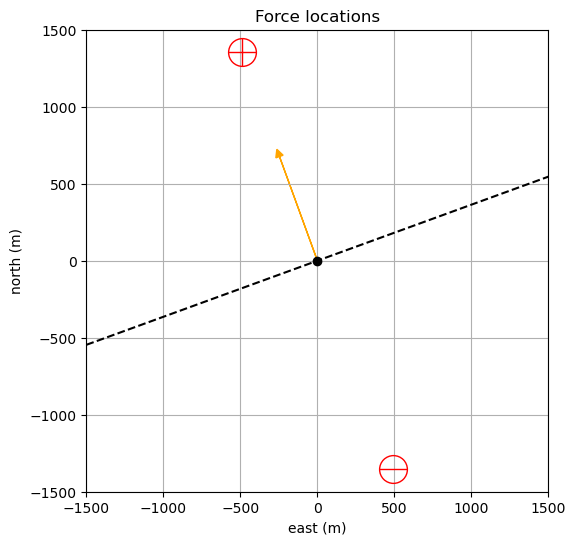

In [364]:
# plot force locations
fig, ax = plt.subplots(figsize=(6, 6))
# center of the fjord
ax.plot(0, 0, 'ko')
# horizontal force
force_h_coords = np.array((force_h_phi, -force_h_theta))
normalization = HORIZONTAL_FORCE_MAGNITUDE_IN_NEWTON / FJORD_WIDTH_IN_METERS * 4
force_h_coords /= normalization
ax.arrow(
    0, 0, force_h_coords[0], force_h_coords[1],
    head_width=50, head_length=50, fc='orange', ec='orange')
# vertical forces
force_v_color = 'red'
force_v_size = 20
ax.plot(
    force_v1_meters_east, force_v1_meters_north, '+',
    color=force_v_color, markersize=force_v_size)
ax.plot(
    force_v1_meters_east, force_v1_meters_north, 'o',
    markeredgecolor=force_v_color, markerfacecolor='none',
    markersize=force_v_size)
ax.plot(
    force_v2_meters_east, force_v2_meters_north, '_',
    color=force_v_color, markersize=force_v_size)
ax.plot(
    force_v2_meters_east, force_v2_meters_north, 'o',
    markeredgecolor=force_v_color, markerfacecolor='none',
    markersize=force_v_size)
# plot a line oriented as the fjord azimuth
x = np.linspace(-1500, 1500, 100)
y = np.tan(np.deg2rad(90-FJORD_AXIS_AZIMUTH_NORTH)) * x
ax.plot(x, y, 'k--')
ax.set_xlim(-1500, 1500)
ax.set_ylim(-1500, 1500)
ax.set_aspect('equal')
ax.set_xlabel('east (m)')
ax.set_ylabel('north (m)')
ax.grid(True)
_ = ax.set_title('Force locations')

## Source Time Function

We use the vertical component of ground displacement at DK.SCO as source time function

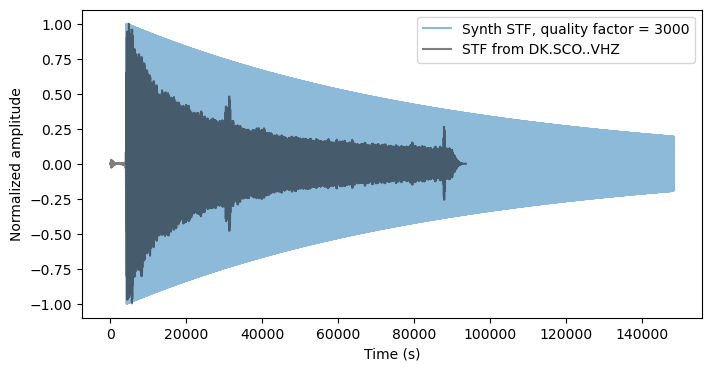

In [366]:
stf_time = np.arange(0, STF_DURATION_IN_SEC, 1./STF_SAMPLING_RATE_IN_HZ)
stf_normalized_time = stf_time * STF_DOMINANT_FREQUENCY_IN_MILLIHZ*1e-3
stf_amplitude = np.sin(2*np.pi*stf_normalized_time)
stf_amplitude *= np.exp(-np.pi*stf_normalized_time/STF_QUALITY_FACTOR)
# Save the source time function in ObsPy trace format, for later use
stf_tr = Trace()
stf_tr.data = stf_amplitude
stf_tr.stats.delta = 1./STF_SAMPLING_RATE_IN_HZ

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized amplitude')
ax.plot(
    stf_time+4300, stf_amplitude, zorder=0, alpha=0.5,
    label=f'Synth STF, quality factor = {STF_QUALITY_FACTOR}')

client = FDSNClient('IRIS')
stf_sco = client.get_waveforms(
    network='DK', station='SCO', location='*', channel='VHZ',
    starttime=UTCDateTime(ORIGIN_TIME)-3600,
    endtime=UTCDateTime(ORIGIN_TIME)+DURATION_IN_SEC+3600,
    attach_response=True
)[0]
stf_sco.detrend('linear')
stf_sco.taper(max_percentage=0.05, type='cosine')
stf_sco.remove_response(output='DISP')
stf_sco.filter(
    'bandpass', freqmin=FILTER_MIN_FREQ_IN_HZ, freqmax=FILTER_MAX_FREQ_IN_HZ)
stf_sco.taper(max_percentage=0.05, type='cosine')
stf_sco.normalize()
ax.plot(
    stf_sco.times(), stf_sco.data, color='k', zorder=1, alpha=0.5,
    label=f'STF from {stf_sco.id}'
)
ax.legend().set_zorder(100)

7.392758755609415


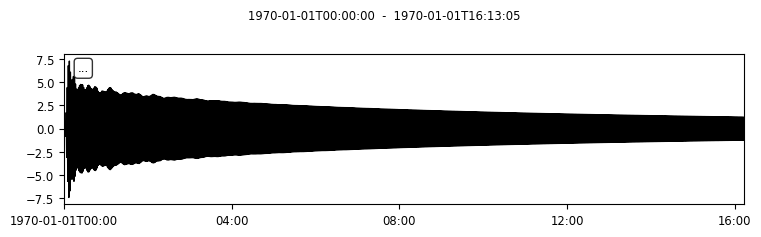

In [367]:



def seiche_sim_to_trace_resample(in_fn):
    df = pd.read_csv(in_fn, header=None, names=["t", "a"], delim_whitespace=True)
    fs = 1000
    seiche_offset = 0
    df = df.set_index(pd.to_datetime(df['t'], unit='s'), drop=False)
    resample_index = pd.date_range(start=df.index[0], end=df.index[-1], freq=f'{fs}ms')
    dummy_frame = pd.DataFrame(np.NaN, index=resample_index, columns=df.columns)
    df_interp = df.combine_first(dummy_frame).interpolate('time').resample(f'{fs}ms').fillna("pad")
    tr = Trace(data=np.array(df_interp["a"].values))
    tr.stats.delta = fs/1000
    tr.stats.starttime = UTCDateTime(df_interp.iloc[0].t) 
    tr2 = tr.copy()
    tr2.detrend()
    tr2.detrend(type="demean")
    tr2.detrend('linear')
    return tr2

tr_g00 = seiche_sim_to_trace_resample("../../../../seiche/Gauge0-Manning0-0x3-dx=3-18hrs.txt")
#tr_g20 = seiche_sim_to_trace_resample("../../../../seiche/Gauge20-Manning0-02-dx=3.txt")
#tr_ave = Trace(data=(tr_g00.data+tr_g20.data)/2)
#tr_ave.stats = tr_g00.stats
tr2 = tr_g00.copy()


tr2.detrend('linear')
tr2.filter(
    'bandpass', freqmin=FILTER_MIN_FREQ_IN_HZ, freqmax=FILTER_MAX_FREQ_IN_HZ)
print(np.max(np.abs(tr2.data)))
tr2.plot()
tr2.normalize()

stf_tr = tr2

## Real data

In [368]:
def get_waveforms(station, origin_time, duration_in_s):
    """
    Get waveforms from IRIS.
    """
    client = FDSNClient('IRIS')
    starttime = UTCDateTime(origin_time) - 3600
    endtime = starttime + duration_in_s
    net, sta = station.split('.')
    if sta == 'SCO':
        loc = '*'
    else:
        loc = '00'
    # chan = 'VH*'
    chan = 'LH*'
    inv = client.get_stations(
        network=net, station=sta, starttime=starttime, endtime=endtime,
        level='response')
    st = client.get_waveforms(
        network=net, station=sta, location=loc, channel=chan,
        starttime=starttime, endtime=endtime)
    st.inventory = inv
    return st

st = get_waveforms(station, ORIGIN_TIME, DURATION_IN_SEC)

In [369]:
def process_stream(
        st, source_latitude, source_longitude,
        filter_min_freq_in_hz, filter_max_freq_in_hz):
    """
    Process the stream.
    """
    st_processed = st.copy()
    st_processed.detrend('linear')
    st_processed.remove_response(
        inventory=st_processed.inventory,
        output='DISP')
    st_processed.taper(max_percentage=0.05, type='cosine')
    st_processed.filter(
        'bandpass',
        freqmin=filter_min_freq_in_hz,
        freqmax=filter_max_freq_in_hz,
    )
    # mute the first 2000 seconds of the signal, to avoid edge effects
    for tr in st_processed:
        npts = int(tr.stats.sampling_rate*2000)
        tr.data[:npts] = 0.
    station_latitude = st_processed.inventory[0][0].latitude
    station_longitude = st_processed.inventory[0][0].longitude
    dist, az, baz = gps2dist_azimuth(
        source_latitude, source_longitude,
        station_latitude, station_longitude)
    print(dist)
    # save distance, back azimuth and coordinated for later use
    st_processed.dist = dist/1e3
    st_processed.baz = baz
    st_processed.coordinates = {
        'latitude': station_latitude,
        'longitude': station_longitude
    }
    st_processed.rotate(
        '->ZNE', inventory=st_processed.inventory)
    st_processed.rotate(
        'NE->RT', back_azimuth=baz)
    return st_processed

st_processed = process_stream(
    st, SOURCE_LATITUDE, SOURCE_LONGITUDE,
    FILTER_MIN_FREQ_IN_HZ, FILTER_MAX_FREQ_IN_HZ)

3243045.78105441


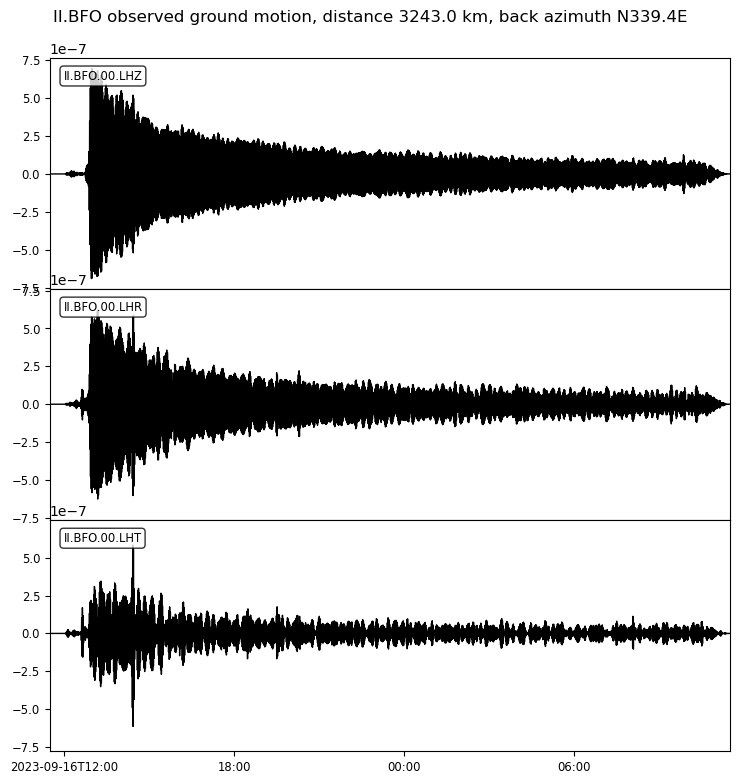

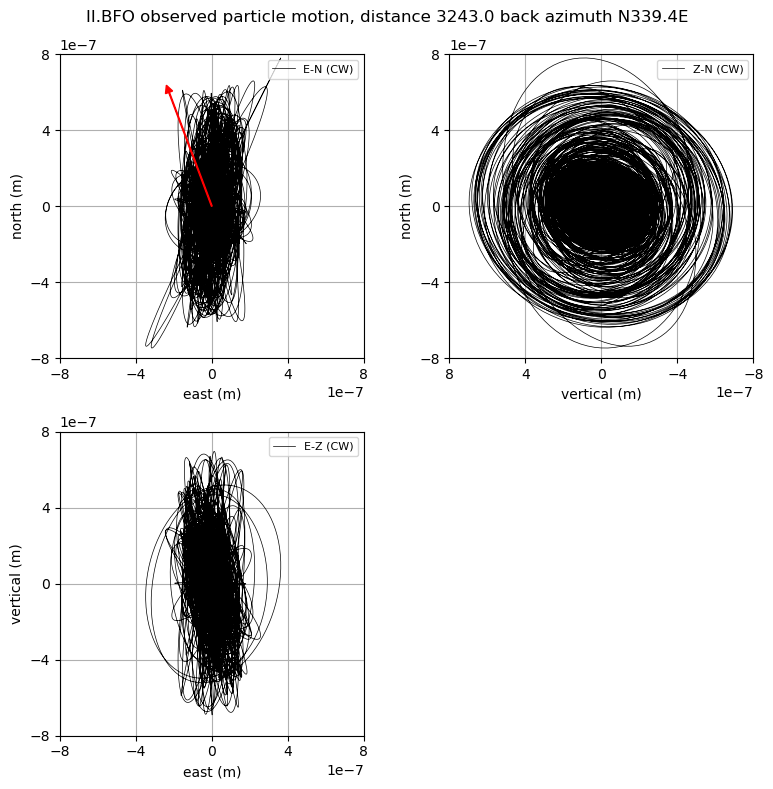

In [370]:
fig = plt.figure(figsize=(8, 8))
title = f'{station} observed ground motion, distance {st_processed.dist:.1f} km, back azimuth N{st_processed.baz:.1f}E'
st_processed.plot(fig=fig)
fig.suptitle(title)
title = f'{station} observed particle motion, distance {st_processed.dist:.1f} back azimuth N{st_processed.baz:.1f}E'
plot_particle_motion(st_processed, 'k', title=title)

## Synthetic data

### Get Green's functions from Syngine

In [371]:
def get_greens(
        source_latitude, source_longitude, source_depth_in_m, origin_time,
        station_latitude, station_longitude,
        force_h_r, force_h_theta, force_h_phi,
        force_v1_r, force_v1_theta, force_v1_phi,
        force_v2_r, force_v2_theta, force_v2_phi):
    """
    Get the Green's functions from Syngine.
    """
    client = SyngineClient()
    model = 'prem_a_20s'
    origintime = UTCDateTime(origin_time)
    starttime = origintime - 3600
    net, sta = station.split('.')
    net = 'SY'
    components = 'ZNE'
    st_green_force_h = client.get_waveforms(
        model=model,
        sourcelatitude=source_latitude, sourcelongitude=source_longitude,
        sourcedepthinmeters=source_depth_in_m,
        receiverlatitude=station_latitude, receiverlongitude=station_longitude,
        sourceforce=[force_h_r, force_h_theta, force_h_phi],
        origintime=origintime,
        starttime=starttime,
        networkcode=net, stationcode=sta,
        components=components,
    )
    st_green_force_v1 = client.get_waveforms(
        model=model,
        sourcelatitude=force_v1_latitude, sourcelongitude=force_v1_longitude,
        sourcedepthinmeters=source_depth_in_m,
        receiverlatitude=station_latitude, receiverlongitude=station_longitude,
        sourceforce=[force_v1_r, force_v1_theta, force_v1_phi],
        origintime=origintime,
        starttime=starttime,
        networkcode=net, stationcode=sta,
        components=components,
    )
    st_green_force_v2 = client.get_waveforms(
        model=model,
        sourcelatitude=force_v2_latitude, sourcelongitude=force_v2_longitude,
        sourcedepthinmeters=source_depth_in_m,
        receiverlatitude=station_latitude, receiverlongitude=station_longitude,
        sourceforce=[force_v2_r, force_v2_theta, force_v2_phi],
        origintime=origintime,
        starttime=starttime,
        networkcode=net, stationcode=sta,
        components=components,
    )
    st_green = st_green_force_h.copy()
    for tr in st_green:
        tr_f_v1 = st_green_force_v1.select(id=tr.id)[0]
        tr_f_v2 = st_green_force_v2.select(id=tr.id)[0]
        tr.data += tr_f_v1.data + tr_f_v2.data
    st_green.coordinates = {
        'latitude': station_latitude,
        'longitude': station_longitude,
    }
    return st_green

station_latitude = st_processed.coordinates['latitude']
station_longitude = st_processed.coordinates['longitude']
st_green = get_greens(
    SOURCE_LATITUDE, SOURCE_LONGITUDE, SOURCE_DEPTH_IN_METERS, ORIGIN_TIME,
    station_latitude, station_longitude,
    force_h_r, force_h_theta, force_h_phi,
    force_v1_r, force_v1_theta, force_v1_phi,
    force_v2_r, force_v2_theta, force_v2_phi,
)

### Process Green's functions

In [372]:
def process_green(
        st_green, stf, time_shift, starttime, endtime,
        source_latitude, source_longitude,
        filter_min_freq_in_hz, filter_max_freq_in_hz):
    """
    Process the Green's functions to obtain synthetic seismograms.
    """
    st_synth = st_green.copy()
    station_latitude = st_synth.coordinates['latitude']
    station_longitude = st_synth.coordinates['longitude']
    _dist, _az, baz = gps2dist_azimuth(
        source_latitude, source_longitude,
        station_latitude, station_longitude)
    # save back azimuth for later use
    st_synth.baz = baz
    st_synth.rotate('NE->RT', back_azimuth=baz)
    for tr in st_synth:
        stf_resample = stf.copy().resample(tr.stats.sampling_rate)
        tr.data = np.convolve(tr.data, stf_resample.data, mode='full')
        tr.data *= tr.stats.delta
        tr.stats.starttime -= time_shift
    st_synth.trim(starttime=starttime, endtime=endtime)
    st_synth.write("/Users/sph1r17/Downloads/BFO_synth.msd", format="MSEED")
    #st_synth.taper(max_percentage=0.05, type='cosine')
    st_synth.filter(
        'bandpass',
        freqmin=filter_min_freq_in_hz,
        freqmax=filter_max_freq_in_hz
    )
    return st_synth

stf = stf_sco if USE_CLOSEST_STATION_AS_STF else stf_tr
stf = stf_tr

# empirical time shift to align the synthetics with the real data
if USE_CLOSEST_STATION_AS_STF:
    time_shift = -350 #3850
else:
    time_shift = -350
starttime = max(tr.stats.starttime for tr in st_processed)
endtime = min(tr.stats.endtime for tr in st_processed)
st_synth = process_green(
    st_green, stf, time_shift, starttime, endtime,
    SOURCE_LATITUDE, SOURCE_LONGITUDE,
    FILTER_MIN_FREQ_IN_HZ, FILTER_MAX_FREQ_IN_HZ)

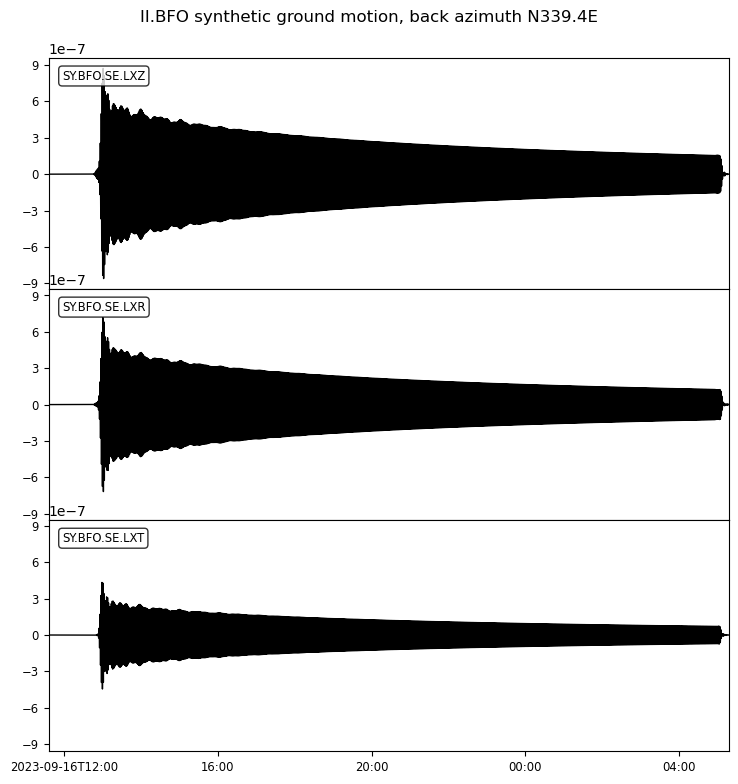

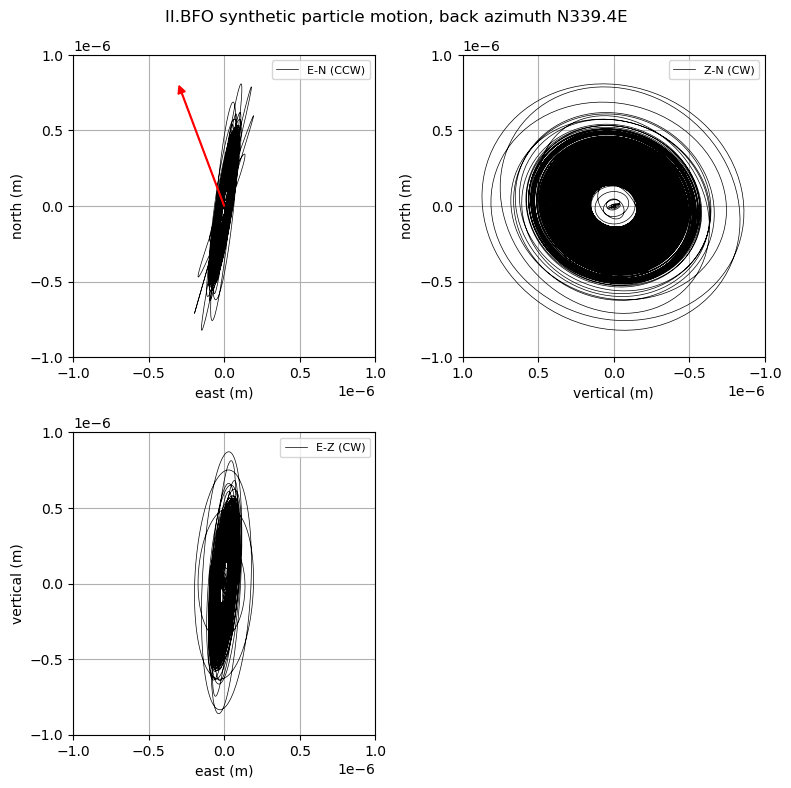

In [373]:
fig = plt.figure(figsize=(8, 8))
title = f'{station} synthetic ground motion, back azimuth N{st_synth.baz:.1f}E'
st_synth.plot(fig=fig)
fig.suptitle(title)
title = f'{station} synthetic particle motion, back azimuth N{st_synth.baz:.1f}E'
plot_particle_motion(st_synth, 'k', title=title)

## Comparison between real and synthetic data

### Misfit

Misfit: 0.211453


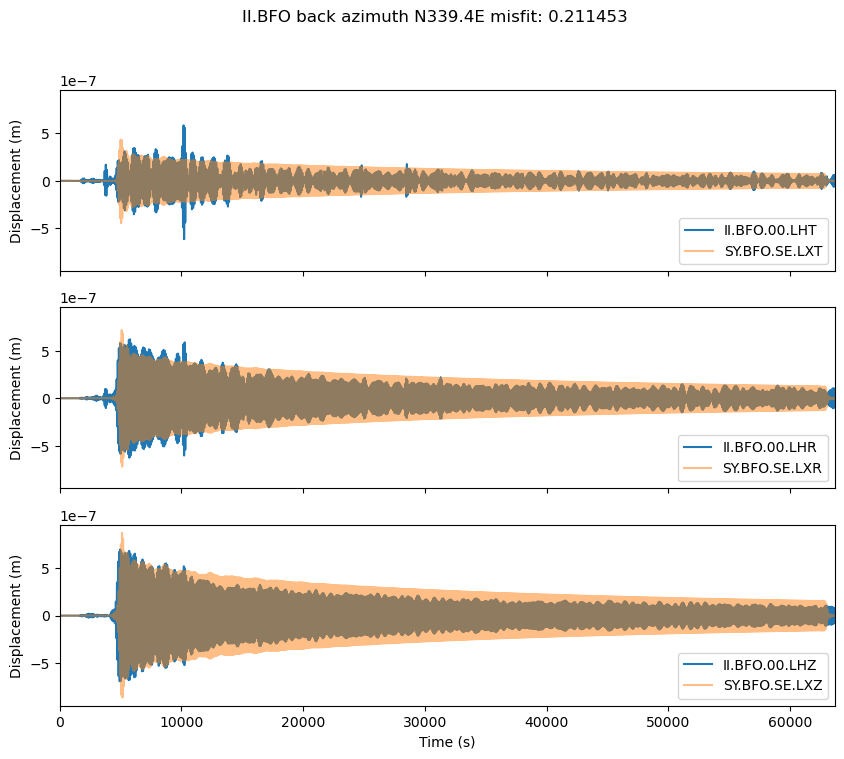

In [374]:
def compute_misfit(st_processed, st_synth, plot=False):
    """
    Compute the misfit between observed and synthetic ground motion.
    """
    # empirical time shift to align the synthetics with the real data
    # need to understand why this is needed
    # if USE_CLOSEST_STATION_AS_STF:
    #     time_shift = 3850
    # else:
    #     time_shift = -350
    st_processed = st_processed.copy()
    st_synth = st_synth.copy()
    # for tr in st_synth:
    #     tr.stats.starttime -= time_shift
    starttime = max(tr.stats.starttime for tr in st_processed+st_synth)
    endtime = min(tr.stats.endtime for tr in st_processed+st_synth)
    st_processed.trim(starttime, endtime)
    st_synth.trim(starttime, endtime)
    misfit = 0
    ntraces = len(st_processed)
    max_obs_data = np.max(np.abs(st_processed.max()))
    for tr_obs in st_processed:
        tr_synth = st_synth.select(component=tr_obs.stats.component)[0]
        npts = len(tr_obs.data)
        misfit += np.sum(
            np.abs(tr_obs.data - tr_synth.data)
        ) / (max_obs_data*npts)
    misfit /= ntraces
    if plot:
        title = (
            f'{station} back azimuth N{st_synth.baz:.1f}E '
            f'misfit: {misfit:.6f}'
        )
        plot_traces(st_processed, st_synth, title)
    return misfit

misfit = compute_misfit(st_processed, st_synth, plot=True)
print(f'Misfit: {misfit:.6f}')

In [375]:
st_synth.write("BFO_synth.msd", format="MSEED")

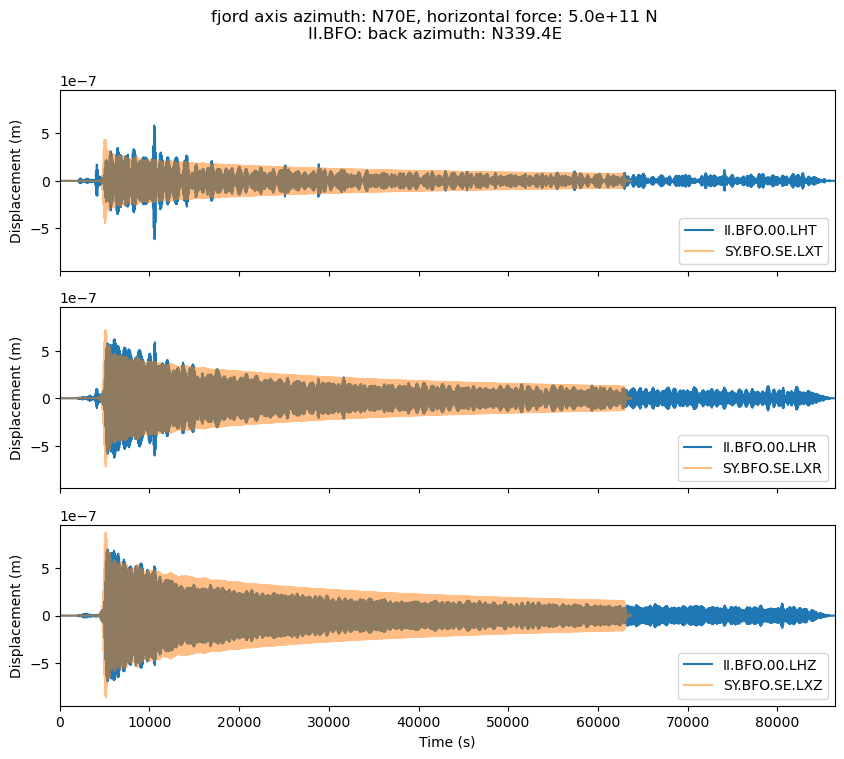

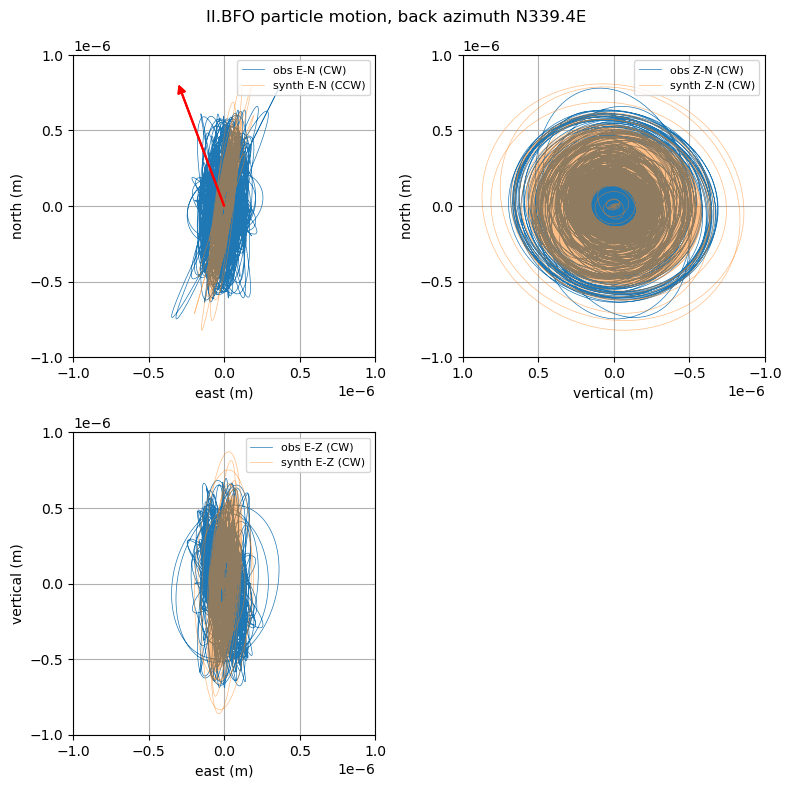

In [376]:
# plot traces and particle motion
title = (
    f'fjord axis azimuth: N{FJORD_AXIS_AZIMUTH_NORTH}E, '
    f'horizontal force: {HORIZONTAL_FORCE_MAGNITUDE_IN_NEWTON:.1e} N\n'
    f'{station}: back azimuth: N{st_processed.baz:.1f}E'
)
plot_traces(st_processed, st_synth, title)
title = f'{station} particle motion, back azimuth N{st_processed.baz:.1f}E'
plot_particle_motion(
    st_processed, 'C0', 'obs', st_synth, 'C1', 'synth', title=title)